# 5장. 차원 축소를 사용한 데이터 압축

In [105]:
%pip install watermark

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [106]:
%load_ext watermark
%watermark -u -d -p numpy,scipy,matplotlib,sklearn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2023-02-02

numpy     : 1.20.1
scipy     : 1.7.3
matplotlib: 3.3.4
sklearn   : 0.0.post1



# 1. 주성분 분석을 통한 비지도 차원 축소

## 주성분 추출 단계별 구현

### 1) 전처리

In [107]:
import pandas as pd

df_wine = pd.read_csv('wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


70%는 훈련 세트로 30%는 테스트 세트로 나눔

In [108]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, 
                     stratify=y,
                     random_state=0)

데이터를 표준화합니다.

In [109]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

### 2) 공분산 행렬 구함
### 3) 고유값, 고유벡터 구함

In [110]:
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\n고윳값 \n%s' % eigen_vals)


고윳값 
[4.8427 2.416  1.5485 0.9612 0.8417 0.6621 0.5183 0.3465 0.3131 0.1075
 0.2136 0.1536 0.1809]


### 총분산과 설명된 분산 : 분산 비율 시각화

고유값의 설명된 분산 비율 = 해당 고유값이 전체 중에서 차지하는 비율

In [111]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

분석결과
- 첫번째 주성분이 40%의 분산(=정보)를 담고있다
- 첫+두번째 주성분이 전체 데이터에 60%를 설명하고 있음 


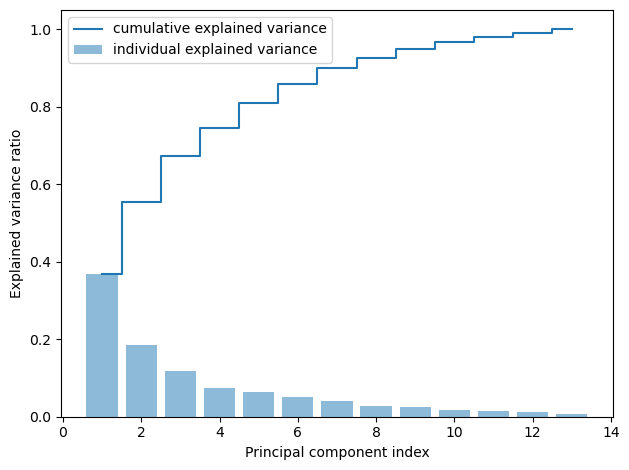

In [112]:
import matplotlib.pyplot as plt


plt.bar(range(1, 14), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### 4) 고유값 내림차순 정렬

In [113]:
# (고윳값, 고유벡터) 튜플의 리스트를 만듭니다
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# 높은 값에서 낮은 값으로 (고윳값, 고유벡터) 튜플을 정렬합니다
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

### 5) K개의 벡터 선택, 투영 행렬 w 만듬
- K=2이고 전체 특성 13개
- => 최상위 고유 벡터 2개로 부터 13x2 투영행렬 w 생성됨

In [114]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('투영 행렬 W:\n', w)

투영 행렬 W:
 [[-0.1372  0.503 ]
 [ 0.2472  0.1649]
 [-0.0255  0.2446]
 [ 0.2069 -0.1135]
 [-0.1544  0.2897]
 [-0.3938  0.0508]
 [-0.4174 -0.0229]
 [ 0.3057  0.0905]
 [-0.3067  0.0084]
 [ 0.0755  0.5498]
 [-0.3261 -0.2072]
 [-0.3686 -0.249 ]
 [-0.2967  0.3802]]


### 6) d차원 입력 데이터 -> w투영 행렬 사용 -> k차원 주성분으로 투영

In [115]:
X_train_std[0].dot(w)

array([2.383 , 0.4546])

### 7) 시각화

- pc1(x축, 첫번째 주성분) / pc2(y축, 두번째 주성분)
- y축보다 x축의 분산이 더 큼(더 퍼짐) => pc1(첫번째 주성분)이 더 많은 정보 포함

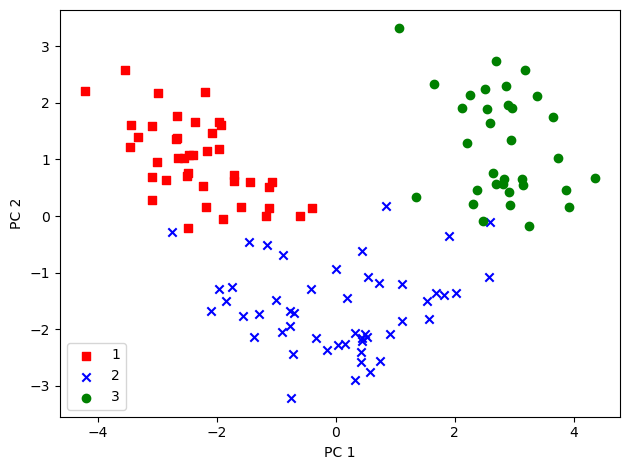

In [116]:
X_train_pca = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

## 사이킷런의 주성분 분석

### 1) wine 데이터 PCA만 진행(직접구현과 동일)

분산 비율

In [117]:
from sklearn.decomposition import PCA

pca = PCA()
# or  pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.3695, 0.1843, 0.1182, 0.0733, 0.0642, 0.0505, 0.0395, 0.0264,
       0.0239, 0.0163, 0.0138, 0.0117, 0.0082])

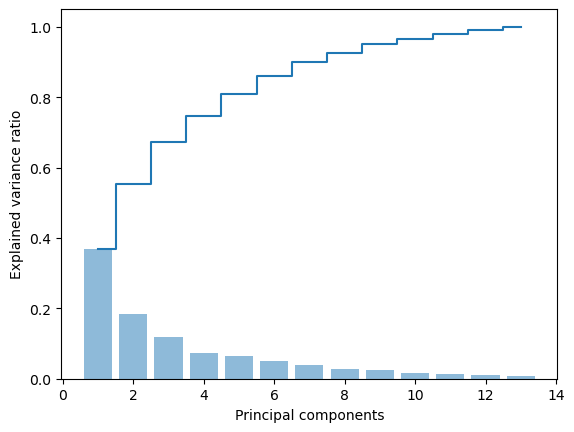

In [118]:
plt.bar(range(1, 14), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 14), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

d차원 입력 데이터 -> k차원 주성분으로 투영

In [119]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

시각화

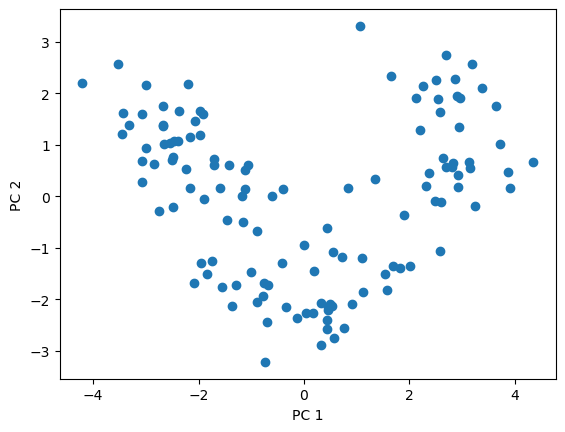

In [120]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

### 2) PCA로 특성추출한 new데이터로 -> 로지스틱 회귀 분류기 훈련 

In [121]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr = LogisticRegression(solver='liblinear', multi_class='auto')
lr = lr.fit(X_train_pca, y_train)

In [122]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # 마커와 컬러맵을 준비합니다
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 결정 경계를 그립니다
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # 클래스 샘플을 표시합니다
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=cmap.colors[idx],
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

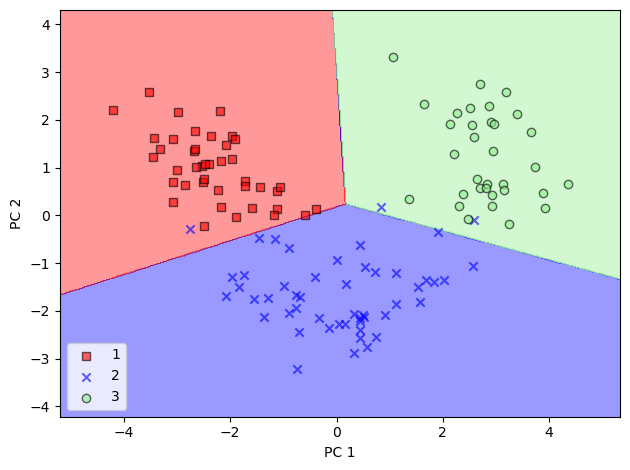

In [123]:
#train 데이터로 시각화 
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

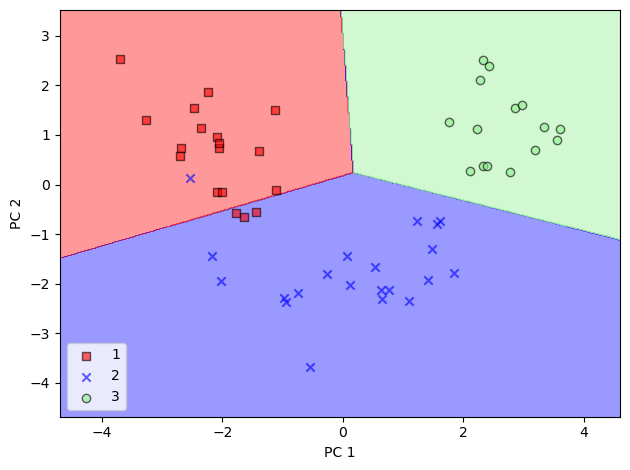

In [124]:
#test 데이터 시각화
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

# 2. 선형 판별 분석을 통한 지도방식의 데이터 압축

## LDA의 단계별 구현

### 1. 전처리
(위에서 이미 한 데이터 이용)

### 2. 각 클레스의 평균 벡터 계산

In [125]:
np.set_printoptions(precision=4)

mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print('MV %s: %s\n' % (label, mean_vecs[label - 1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



### 3-1. 클래스 내 산포 행렬을 계산

클레스에 레이블 분포 확인

In [126]:
print('클래스 레이블 분포: %s' 
      % np.bincount(y_train)[1:])

클래스 레이블 분포: [41 50 33]


if> 클레스가 균일하게 분포 되어 있을 때 -> 산포 행렬

In [127]:
d = 13 # 특성의 수
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d)) 
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter              

print('클래스 내의 산포 행렬: %sx%s' % (S_W.shape[0], S_W.shape[1]))

클래스 내의 산포 행렬: 13x13


if> 클레스가 균일하게 분포 되어 있지 않을 때 -> 공분산 행렬

In [128]:
d = 13  # 특성의 수
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T, bias=True)
    S_W += class_scatter
print('스케일 조정된 클래스 내의 산포 행렬: %sx%s' % (S_W.shape[0],S_W.shape[1]))

스케일 조정된 클래스 내의 산포 행렬: 13x13


### 3-2. 클래스 간 산포 행렬을 계산

In [129]:
mean_overall = np.mean(X_train_std, axis=0)
mean_overall = mean_overall.reshape(d, 1)  # 열 벡터로 만들기
d = 13  # 특성의 수
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  # 열 벡터로 만들기
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('클래스 간의 산포 행렬: %sx%s' % (S_B.shape[0], S_B.shape[1]))

클래스 간의 산포 행렬: 13x13


### 4. 행렬 $S_W^{-1}S_B$의 고유값, 고유벡터 계산

In [130]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

### 5. 고윳값의 역순으로 고유 벡터를 정렬

In [131]:
# (고윳값, 고유벡터) 튜플의 리스트를 만듭니다.
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# (고윳값, 고유벡터) 튜플을 큰 값에서 작은 값 순서대로 정렬합니다.
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

# 고윳값의 역순으로 올바르게 정렬되었는지 확인합니다.

print('내림차순의 고윳값:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

내림차순의 고윳값:

358.0042070133658
177.0776864066622
3.398314721200052e-14
3.398314721200052e-14
3.326348342454073e-14
2.842170943040401e-14
1.8539843038811974e-14
1.7207938692685766e-14
1.7207938692685766e-14
8.507407811057449e-15
8.507407811057449e-15
3.8366434972524954e-15
2.0724492604416364e-15


### 선형 판별 벡터 정보 비율 시각화

결과 분석: 앞에서 두개의 선형 판별 벡터가 wine데이터셋의 정보 100%를 잡아냄

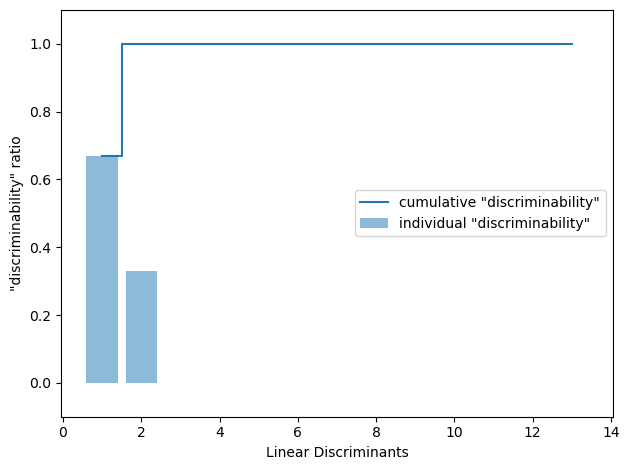

In [132]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, alpha=0.5, align='center',
        label='individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid',
         label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### 6. 고유값이 가장 큰 k개 벡터 선택, 변환 벡터 W 생성

In [133]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))
print('행렬 W:\n', w)

행렬 W:
 [[-0.1484 -0.4093]
 [ 0.091  -0.1583]
 [-0.0168 -0.3536]
 [ 0.1487  0.322 ]
 [-0.0165 -0.0813]
 [ 0.1912  0.0841]
 [-0.7333  0.2828]
 [-0.0751 -0.0099]
 [ 0.002   0.0902]
 [ 0.2953 -0.2168]
 [-0.0327  0.274 ]
 [-0.3539 -0.0133]
 [-0.3918 -0.5954]]


### 7. 새로운 특성 공간으로 샘플 투영

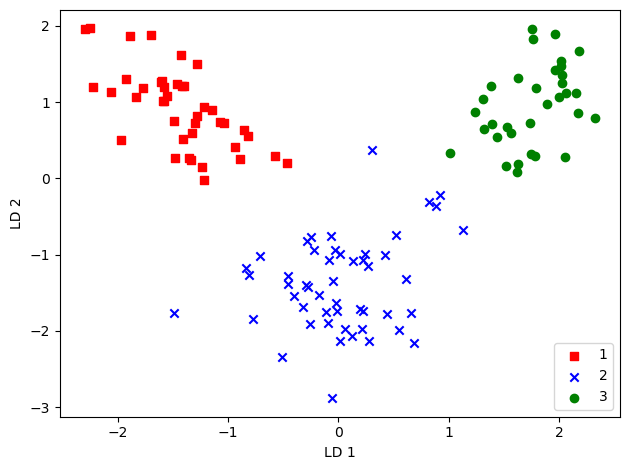

In [134]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0],
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=l, marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## 사이킷런의 LDA

### 1) WINE 데이터 LDA 진행

In [135]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

### 2) LDA로 특성추출한 new데이터로 -> 로지스틱 회귀 분류기 훈련 

Train 결과: 클레스 2 샘플 하나를 구별해 내지 못했다

In [136]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='liblinear', multi_class='auto')
lr = lr.fit(X_train_lda, y_train)

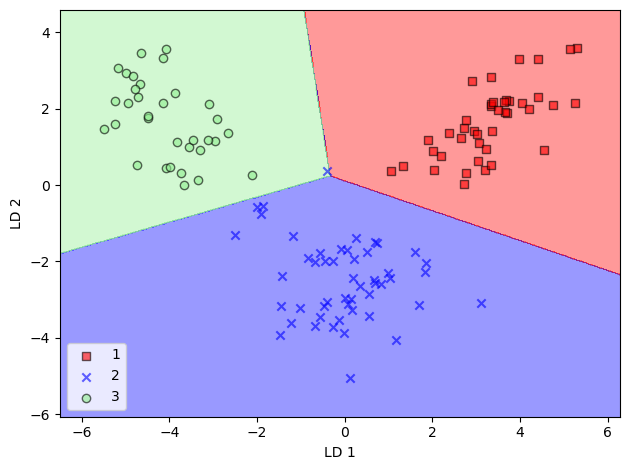

In [137]:
#시각화
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

Test결과: 완벽하게 분류해냈다

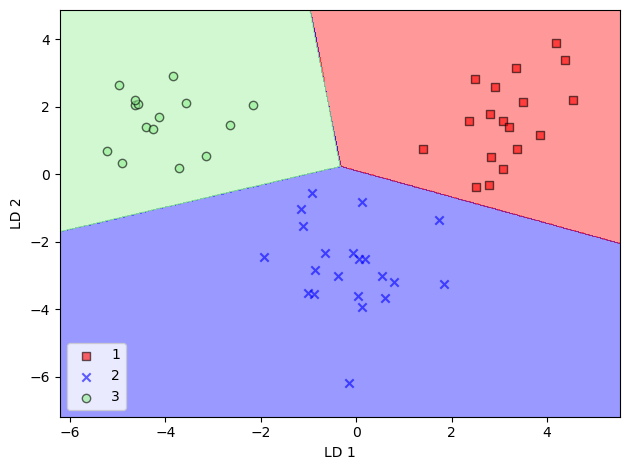

In [138]:
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

# 3. 커널 PCA를 사용하여 비선형 매핑하기

## 커널 PCA 단계별 구현

RBF 커널 PCA 구현
- 단점 : gamma: float / RBF 커널 튜닝 매개변수를 직접 지정해줘야함
=> 그리디 서치와 같은 알고리즘으로 최적화 값 찾을 수 있음 (6장)

In [139]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    매개변수
    X: {넘파이 ndarray}, shape = [n_samples, n_features]
    gamma: float / RBF 커널 튜닝 매개변수
    n_components: int / 반환할 주성분 개수
    ------------
    반환값
    X_pc: {넘파이 ndarray}, shape = [n_samples, k_features] / 투영된 데이터셋
    """

### 과정1
    # MxN 차원의 데이터셋에서 샘플 간의 유클리디안 거리의 제곱을 계산
    sq_dists = pdist(X, 'sqeuclidean')
    # 샘플 간의 거리를 정방 대칭 행렬로 변환
    mat_sq_dists = squareform(sq_dists)
    # 커널 행렬을 계산
    K = exp(-gamma * mat_sq_dists)

### 과정 2
    # 커널 행렬을 중앙에 맞춤
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

### 과정 3
    # 중앙에 맞춰진 커널 행렬의 고윳값과 고유벡터를 구함
    # scipy.linalg.eigh 함수는 오름차순으로 반환
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # 최상위 k 개의 고유벡터를 선택(결과값은 투영된 샘플).
    X_pc = np.column_stack([eigvecs[:, i]
                            for i in range(n_components)])

    return X_pc

### 예제 1: 반달 모양 구분하기

1) 비선형 데이터셋 생성

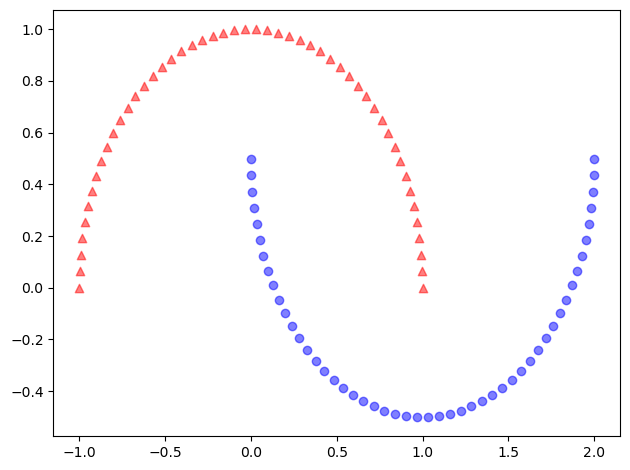

In [140]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, random_state=123)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
plt.show()

2-1) 일반 PCA 적용
- 결과(오른쪽): 선형 분류기에서 판별 할 수 없는 new데이터가 만들어짐

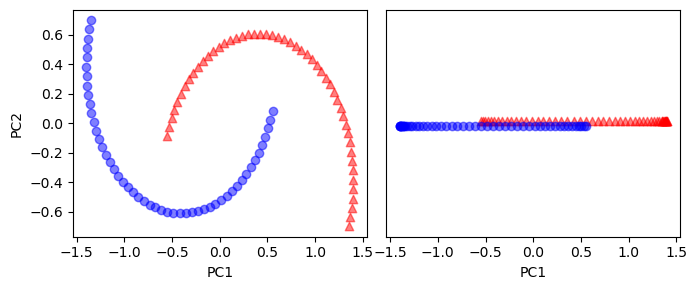

In [141]:
from sklearn.decomposition import PCA

scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((50, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((50, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
plt.show()

2-2) rbf 커널 pca 적용
- 결과(오른쪽): 두 클레스가 선형적으로 구분이 잘 되도록 분리됨 => 선형 분류기 사용 가능한 형태가 됨

C:\Users\jsm36\AppData\Local\Temp\ipykernel_18660\1539580623.py:23: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  K = exp(-gamma * mat_sq_dists)


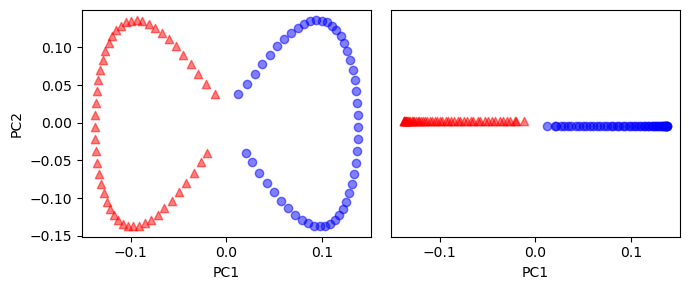

In [142]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], 
            color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
            color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y==0, 0], np.zeros((50,1))+0.02, 
            color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50,1))-0.02,
            color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
plt.show()

### 예제 2: 동심원 분리하기

1. 비선형 데이터 생성

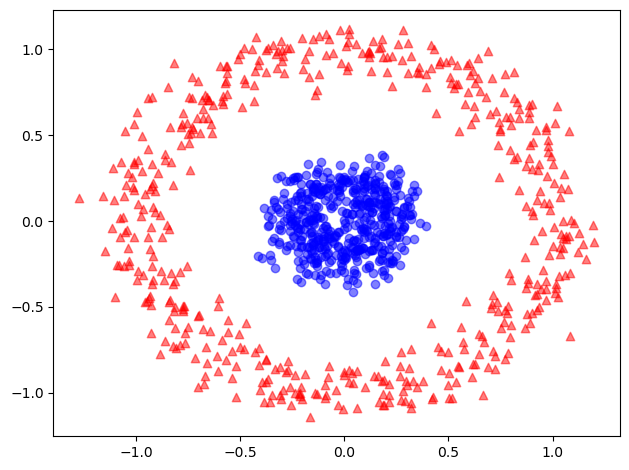

In [143]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
plt.show()

2-1) 일반 PCA 적용
- 결과(오른쪽): 선형 분류기에서 판별 할 수 없는 new데이터가 만들어짐

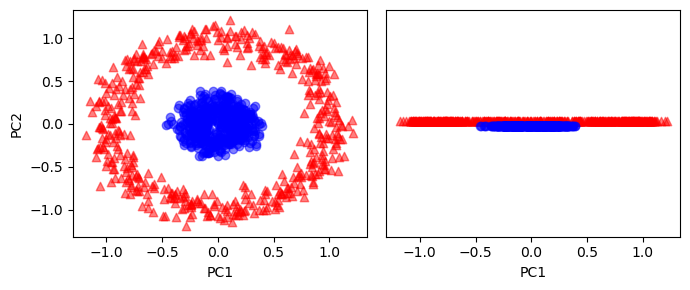

In [144]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
plt.show()

2-2) rbf 커널 pca 적용
- 결과(오른쪽): 두 클레스가 선형적으로 구분이 잘 되도록 분리됨 => 선형 분류기 사용 가능한 형태가 됨

C:\Users\jsm36\AppData\Local\Temp\ipykernel_18660\1539580623.py:23: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  K = exp(-gamma * mat_sq_dists)


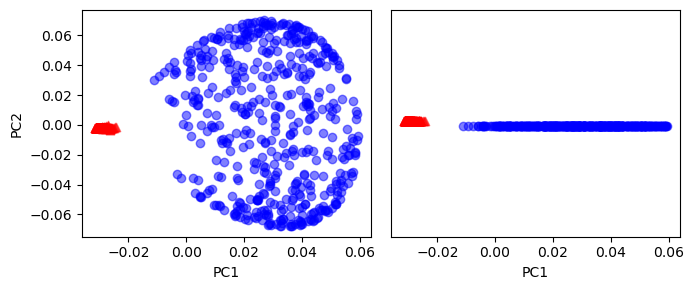

In [145]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
plt.show()

## 새로운 데이터 포인트 투영하기

새로운 데이터 투영하는 RBF 커널 PCA 구현
- 기존ver에서 고유값을 반환하도록 수정

In [146]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    매개변수
    X: {넘파이 ndarray}, shape = [n_samples, n_features]
    gamma: float / RBF 커널 튜닝 매개변수
    n_components: int / 반환할 주성분 개수
    ------------
    반환값
    alphas: {넘파이 ndarray}, shape = [n_samples, k_features] // 투영된 데이터셋
    ###lambdas: list // 고윳값 
    """
### 과정1
    # MxN 차원의 데이터셋에서 샘플 간의 유클리디안 거리의 제곱을 계산
    sq_dists = pdist(X, 'sqeuclidean')
    # 샘플 간의 거리를 정방 대칭 행렬로 변환
    mat_sq_dists = squareform(sq_dists)
    # 커널 행렬을 계산합니다.
    K = exp(-gamma * mat_sq_dists)

### 과정 2
    # 커널 행렬을 중앙에 맞춤.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

### 과정 3
    # 중앙에 맞춰진 커널 행렬의 고윳값과 고유 벡터를 구함
    # scipy.linalg.eigh 함수는 오름차순으로 반환
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # 최상위 k 개의 고유 벡터를 선택합니다(투영 결과).
    alphas = np.column_stack([eigvecs[:, i]
                              for i in range(n_components)])

    # 고유 벡터에 상응하는 고윳값을 선택합니다. => 차이점
    lambdas = [eigvals[i] for i in range(n_components)]

    return alphas, lambdas # => 고유값도 같이 반환

1. 데이터셋 생성
2. 새로운 데이터 투영할 수 있는 수정한 rbf_pca 학습

In [147]:
X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas = rbf_kernel_pca(X, gamma=15, n_components=1)

C:\Users\jsm36\AppData\Local\Temp\ipykernel_18660\1308053615.py:47: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  K = exp(-gamma * mat_sq_dists)


In [148]:
x_new = X[25]
x_new

array([1.8713, 0.0093])

In [149]:
x_proj = alphas[25] # 원본 투영
x_proj

array([0.0788])

3. 새로운 데이터 투영

In [150]:
def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum((x_new - row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)

# 새로운 데이터포인트를 투영합니다.
x_reproj = project_x(x_new, X, gamma=15, alphas=alphas, lambdas=lambdas)
x_reproj 

array([0.0788])

4. 시각화
- 결과:  새로운 데이터가 올바르게 매핑됨

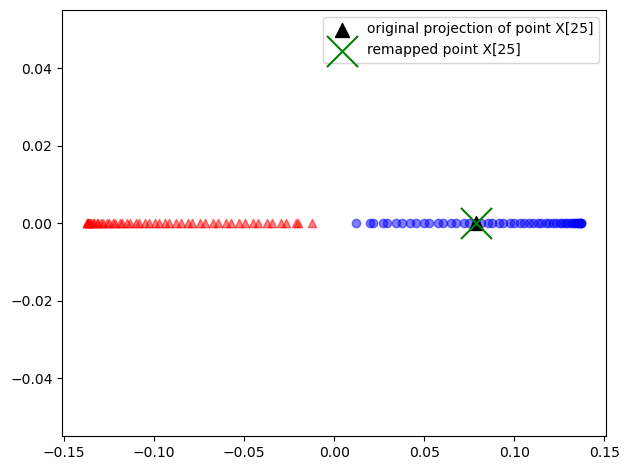

In [151]:
plt.scatter(alphas[y == 0, 0], np.zeros((50)),
            color='red', marker='^', alpha=0.5)
plt.scatter(alphas[y == 1, 0], np.zeros((50)),
            color='blue', marker='o', alpha=0.5)
plt.scatter(x_proj, 0, color='black',
            label='original projection of point X[25]', marker='^', s=100)
plt.scatter(x_reproj, 0, color='green',
            label='remapped point X[25]', marker='x', s=500)
plt.legend(scatterpoints=1)

plt.tight_layout()
plt.show()

## 사이킷런의 커널 PCA

kernel='rbf' 로 커널 지정해줌
- 결과: 직접 구현 한 것과 같음

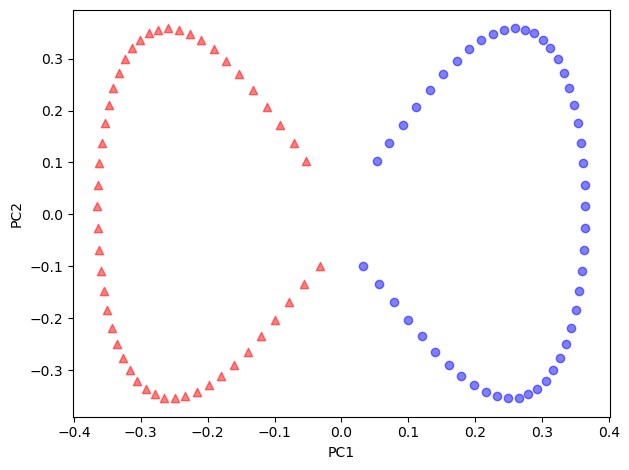

In [152]:
from sklearn.decomposition import KernelPCA

X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

plt.scatter(X_skernpca[y == 0, 0], X_skernpca[y == 0, 1],
            color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y == 1, 0], X_skernpca[y == 1, 1],
            color='blue', marker='o', alpha=0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()